## Language Translator

In [1]:
import nltk
import pandas as pd
import numpy as np
import re
from collections import Counter
import pickle
from nltk.corpus import comtrans

In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras import optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

From `nltk` we can download translated sentences between different languages. You can see the example between **English and French** below but feel free to try different combination as well.

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [5]:
data = read_text("fra.txt")
fra_eng = to_lines(data)
fra_eng = array(fra_eng)

In [6]:
fra_eng = fra_eng[:60000,:2]

In [7]:
fra_eng

array([['Go.', 'Va !'],
       ['Go.', 'Marche.'],
       ['Go.', 'Bouge !'],
       ...,
       ['I do that for the money.', "Je fais ça pour l'argent."],
       ['I do think I understand.',
        'Je pense vraiment que je comprends.'],
       ["I don't agree with this.", "Je ne suis pas d'accord avec ça."]],
      dtype='<U325')

### 1. Tokenize and Clean Text

In [8]:
# Remove punctuation
fra_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,0]]
fra_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,1]]

In [9]:
# convert to lowercase
for i in range(len(fra_eng)):
    fra_eng[i,0] = fra_eng[i,0].lower()
    
    fra_eng[i,1] = fra_eng[i,1].lower()

In [10]:
fra_eng

array([['go', 'va '],
       ['go', 'marche'],
       ['go', 'bouge '],
       ...,
       ['i do that for the money', 'je fais ça pour largent'],
       ['i do think i understand', 'je pense vraiment que je comprends'],
       ['i dont agree with this', 'je ne suis pas daccord avec ça']],
      dtype='<U325')

In [11]:
df = pd.DataFrame([fra_eng[:,0], fra_eng[:,1]]).T
df.columns=['english', 'french']
df.head(20)

,english,french
0,go,va
1,go,marche
2,go,bouge
3,hi,salut
4,hi,salut
5,run,cours
6,run,courez
7,run,prenez vos jambes à vos cous
8,run,file
9,run,filez


### 2. Convert text to numerical format (Embedding)

In [12]:
arr = df.to_numpy()
arr

array([['go', 'va '],
       ['go', 'marche'],
       ['go', 'bouge '],
       ...,
       ['i do that for the money', 'je fais ça pour largent'],
       ['i do think i understand', 'je pense vraiment que je comprends'],
       ['i dont agree with this', 'je ne suis pas daccord avec ça']],
      dtype=object)

In [13]:
type(arr)

numpy.ndarray

In [14]:
arr.shape

(60000, 2)

In [15]:
en_sent = arr[:,0]
fr_sent = arr[:,1]

In [16]:
en_sent[0]

'go'

In [17]:
# limit sentences upto 8 words
def filter_sentence_length(sentences_l1, sentences_l2, min_len=0, max_len=8):
    filtered_sentences_l1 = []
    filtered_sentences_l2 = []
    for i in range(len(sentences_l1)):
        s_l1 = sentences_l1[i].split()
        s_l2 = sentences_l2[i].split()
        if (min_len <= len(s_l1) <= max_len) and (min_len <= len(s_l2) <= max_len):
            filtered_sentences_l1.append(sentences_l1[i])
            filtered_sentences_l2.append(sentences_l2[i])
    return filtered_sentences_l1, filtered_sentences_l2

In [18]:
# new sentence lists limited to 8 words
en_sent_lst, fr_sent_lst = filter_sentence_length(en_sent, fr_sent)
print('Total number of sentences')
print(len(en_sent_lst))
assert len(en_sent_lst) == len(fr_sent_lst)

Total number of sentences
59761


In [19]:
en_fr_df = pd.DataFrame([en_sent_lst, fr_sent_lst]).T

In [20]:
en_fr_df.columns=['English', 'French']
en_fr_df.tail(20)

,English,French
59741,i didnt rescue anybody,je nai sauvé personne
59742,i didnt say i liked it,je nai pas dit que jaimais ça
59743,i didnt say i liked it,je nai pas dit que jappréciais ça
59744,i didnt say i liked it,je nai pas dit que je lappréciais
59745,i didnt see any tigers,je nai vu aucun tigre
59746,i didnt see any tigers,je nai pas vu de tigres
59747,i didnt speak for long,je nai pas parlé longtemps
59748,i didnt spend anything,je nai rien dépensé
59749,i didnt touch anything,je nai rien touché
59750,i didnt work yesterday,je ne travaillais pas hier


In [21]:
en_fr_df = en_fr_df[en_fr_df['English']!='']

In [22]:
en_fr_df[en_fr_df['French']=='']

,English,French


In [23]:
arr = en_fr_df.to_numpy()
arr[-4]

array(['i do not understand you', 'je ne vous comprends pas'],
      dtype=object)

In [24]:
arr.shape

(59761, 2)

In [25]:
# Embed and pad english sentences
maxlen = 8
t_en = Tokenizer()
t_en.fit_on_texts(arr[:,0]) # .fit (change characters to dictionary with indexes)
tokenized_en = t_en.texts_to_sequences(arr[:,0]) # .transform
padded_en = pad_sequences(tokenized_en, maxlen=maxlen) # make everything fixed length

print(padded_en.shape)

(59761, 8)


In [26]:
padded_en[0]

array([ 0,  0,  0,  0,  0,  0,  0, 30], dtype=int32)

In [27]:
# Embed and pad french sentences
maxlen = 8
t_fr = Tokenizer()
t_fr.fit_on_texts(arr[:,1]) # .fit (change characters to dictionary with indexes)
tokenized_fr = t_fr.texts_to_sequences(arr[:,1]) # .transform
padded_fr = pad_sequences(tokenized_fr, maxlen=maxlen) # make everything fixed length

print(padded_fr.shape)

(59761, 8)


In [28]:
#t.word_index

In [29]:
train_X = np_utils.to_categorical(padded_fr) # one hot encoding
train_X.shape

(59761, 8, 15700)

In [30]:
train_Y = np_utils.to_categorical(padded_en) # one hot encoding
train_Y.shape

(59761, 8, 6682)

In [31]:
print(train_X.shape[2], train_X.shape[1], train_Y.shape[1], train_Y.shape[2])

15700 8 8 6682


In [32]:
## build model

model = Sequential()
model.add(Embedding(train_X.shape[2], 512, input_length=train_X.shape[1]))
model.add(LSTM(512))
#model.add(Dropout(0.2))
model.add(RepeatVector(train_Y.shape[1])) # output 8x512
model.add(LSTM(512, return_sequences=True)) # input 8x512, output 8x512
#model.add(Dropout(0.2))
model.add(Dense(train_Y.shape[2], activation='softmax')) # input 8x512, output 8xen_vocab_size

model.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Please note that we have used ‘sparse_categorical_crossentropy‘ as the loss function. This is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory.

In [33]:
train_fr, test_fr, train_en, test_en = train_test_split(padded_fr, padded_en, test_size=0.2)

In [34]:
train_fr.shape

(47808, 8)

In [35]:
test_fr.shape

(11953, 8)

In [36]:
train_fr

array([[   0,    0,    0, ...,    0,   91,  793],
       [   0,    0,   37, ..., 1741,    9,  677],
       [   0,    0,    0, ...,  155,    9, 1584],
       ...,
       [   1,   22,   15, ...,   12,  175,  249],
       [   0,    0,    0, ...,   25,  158, 1528],
       [   0,    0,    0, ...,    2,   10,  220]], dtype=int32)

In [37]:
history = model.fit(train_fr, train_en.reshape(train_en.shape[0], train_en.shape[1], 1), 
          epochs=20, batch_size=512, 
          validation_split = 0.2,
          verbose=1)

Epoch 1/20
75/75 [==============================] - 258s 3s/step - loss: 4.4356 - accuracy: 0.4877 - val_loss: 3.1960 - val_accuracy: 0.5199
Epoch 2/20
75/75 [==============================] - 233s 3s/step - loss: 3.1811 - accuracy: 0.5216 - val_loss: 3.0800 - val_accuracy: 0.5235
Epoch 3/20
75/75 [==============================] - 247s 3s/step - loss: 3.0700 - accuracy: 0.5250 - val_loss: 3.0361 - val_accuracy: 0.5319
Epoch 4/20
75/75 [==============================] - 231s 3s/step - loss: 2.9664 - accuracy: 0.5317 - val_loss: 2.8874 - val_accuracy: 0.5394
Epoch 5/20
75/75 [==============================] - 241s 3s/step - loss: 2.8259 - accuracy: 0.5410 - val_loss: 2.7861 - val_accuracy: 0.5440
Epoch 6/20
75/75 [==============================] - 248s 3s/step - loss: 2.7001 - accuracy: 0.5499 - val_loss: 2.6834 - val_accuracy: 0.5542
Epoch 7/20
75/75 [==============================] - 226s 3s/step - loss: 2.5576 - accuracy: 0.5627 - val_loss: 2.4949 - val_accuracy: 0.5740
Epoch 8/20
75

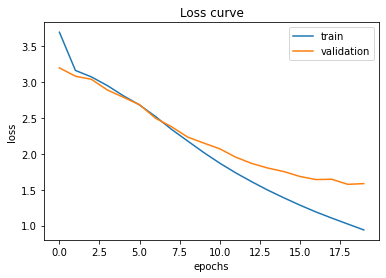

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss curve')
plt.show()

In [39]:
preds = model.predict_classes(test_fr.reshape((test_fr.shape[0],test_fr.shape[1])))

/Users/pavneetbajwa/opt/anaconda3/envs/labs/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [40]:
preds.shape

(11953, 8)

In [41]:
translated = t_en.sequences_to_texts(preds)
len(translated)

11953

In [42]:
original = t_fr.sequences_to_texts(test_fr)

In [43]:
original_en = t_en.sequences_to_texts(test_en)

In [44]:
df_translated = pd.DataFrame([original, original_en, translated]).T

In [45]:
df_translated.columns = ['French', 'English', 'Translated']

In [46]:
df_translated

,French,English,Translated
0,il se mit au lit,he went to bed,he to to bed
1,faismoi circuler linformation,keep me in the loop,me the chinese
2,cest un garçon très honnête,the boy is very honest,he is very very man
3,la porte est verrouillée,the doors locked,the the is locked
4,cest injuste,thats unfair,not weird
...,...,...,...
11948,estu prête à y aller,are you ready to go,are you ready to go
11949,aije lair occupée selon toi,do i look busy to you,do i look look to you
11950,tu dois me faire confiance,youve got to trust me,you to trust me
11951,pratiquezvous le moindre sport,do you play any sports,do you like a band


In [132]:
df_translated.sample(10)

,French,English,Translated
10140,cest mon désir,thats my wish,is my assistant
2307,je veux quon me choie,i want to be pampered,i want to to stand
3326,jai assisté au séminaire,i attended the seminar,i rang the sunday
11718,tom restait immobile,tom wasnt moving,tom remained confused
5317,tu devrais parler à tom,you should talk to tom,you should to tom
6811,quattendonsnous,whatre we waiting for,it it
2717,elle lui a raconté une blague,she told him a joke,she gave him a joke
5442,je pense que tu as besoin de ceci,i think you need this,i you you you this
10209,raccrochez,hang up the phone,you it
1937,il navait pas dargent,he had no money,he has no money


In [102]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 512)            8038400   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 8, 6682)           3427866   
Total params: 15,664,666
Trainable params: 15,664,666
Non-trainable params: 0
_________________________________________________________________
